In [1]:
# Youngwoo Kim
!hdfs dfs -D dfs.replication=1 -cp -f data/*.csv hdfs://nn:9000/

In [2]:
!hdfs dfs -du -h hdfs://nn:9000/*

328      328      hdfs://nn:9000/action_taken.csv
317      317      hdfs://nn:9000/agency.csv
521.0 K  521.0 K  hdfs://nn:9000/arid2017_to_lei_xref_csv.csv
311.6 K  311.6 K  hdfs://nn:9000/counties.csv
237      237      hdfs://nn:9000/denial_reason.csv
109      109      hdfs://nn:9000/edit_status.csv
180      180      hdfs://nn:9000/ethnicity.csv
166.8 M  166.8 M  hdfs://nn:9000/hdma-wi-2021.csv
41       41       hdfs://nn:9000/hoepa.csv
114      114      hdfs://nn:9000/lien_status.csv
65       65       hdfs://nn:9000/loan_purpose.csv
79       79       hdfs://nn:9000/loan_type.csv
247      741      hdfs://nn:9000/model/metadata
5.4 K    16.2 K   hdfs://nn:9000/model/stages
129.6 K  129.6 K  hdfs://nn:9000/msamd.csv
122      122      hdfs://nn:9000/owner_occupancy.csv
92       92       hdfs://nn:9000/preapproval.csv
127      127      hdfs://nn:9000/property_type.csv
387      387      hdfs://nn:9000/purchaser_type.csv
252      252      hdfs://nn:9000/race.csv
144      144      hdfs://nn:

In [3]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/11 00:23:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
banks_df = spark.read.options(header=True, inferSchema=True).csv("hdfs://nn:9000/arid2017_to_lei_xref_csv.csv")

In [5]:
type(banks_df)

pyspark.sql.dataframe.DataFrame

In [6]:
banks_df.rdd.take(3)

[Row(respondent_name='First National Bank', arid_2017='110004', lei_2018='5493003EW6T31TGECO83', lei_2019='5493003EW6T31TGECO83', lei_2020='5493003EW6T31TGECO83'),
 Row(respondent_name='First Mid Bank & Trust, National Association', arid_2017='110045', lei_2018='549300XOTES5TCS8T794', lei_2019='549300XOTES5TCS8T794', lei_2020='549300XOTES5TCS8T794'),
 Row(respondent_name='First Hope Bank, A National Banking Association', arid_2017='110118', lei_2018='5493003XLOX5FDT9R120', lei_2019='5493003XLOX5FDT9R120', lei_2020='5493003XLOX5FDT9R120')]

In [7]:
#q1
banks_df.rdd.filter(lambda x:"first" in x.respondent_name.lower()).count()

525

In [8]:
from pyspark.sql.functions import lower

In [9]:
#q2
banks_df.filter(lower(banks_df.respondent_name).like("%first%")).count()

525

In [10]:
#q3
banks_df.write.saveAsTable("banks", mode="overwrite")
spark.sql("""
            SELECT * FROM banks
            WHERE LOWER(respondent_name) LIKE '%first%'
            """).count()

23/11/11 00:23:59 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/11 00:23:59 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/11/11 00:24:04 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/11/11 00:24:04 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.22.0.6
23/11/11 00:24:05 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException
23/11/11 00:24:10 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/11/11 00:24:10 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/11/11 00:24:10 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/11/11 00:24:10 W

525

In [11]:
loans_df = spark.read.options(header=True, inferSchema=True).csv("hdfs://nn:9000/hdma-wi-2021.csv")
loans_df.write.bucketBy(8, 'county_code').saveAsTable("loans", mode="overwrite")

23/11/11 00:24:26 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [12]:
list_of_tables = ["ethnicity", "race", "sex", "states", "counties", "tracts", "action_taken",
 "denial_reason", "loan_type", "loan_purpose", "preapproval", "property_type"]

In [13]:
for name in list_of_tables:
    spark.read.options(header=True, inferSchema=True).csv(f"hdfs://nn:9000/{name}.csv").createOrReplaceTempView(f"{name}")

In [14]:
#q4
tables = spark.sql("SHOW TABLES").toPandas()
result = {}
for i, row in tables.iterrows():
    result[row['tableName']] = row['isTemporary']
result

{'banks': False,
 'loans': False,
 'action_taken': True,
 'counties': True,
 'denial_reason': True,
 'ethnicity': True,
 'loan_purpose': True,
 'loan_type': True,
 'preapproval': True,
 'property_type': True,
 'race': True,
 'sex': True,
 'states': True,
 'tracts': True}

In [15]:
#q5
spark.sql("""
            SELECT lei_2020, respondent_name FROM banks
            INNER JOIN loans ON banks.lei_2020=loans.lei
            WHERE respondent_name = 'University of Wisconsin Credit Union'
            """).count()

19739

In [16]:
spark.sql("""
            SELECT * FROM banks
            LIMIT 3
            """).toPandas()

,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,First National Bank,110004,5493003EW6T31TGECO83,5493003EW6T31TGECO83,5493003EW6T31TGECO83
1,"First Mid Bank & Trust, National Association",110045,549300XOTES5TCS8T794,549300XOTES5TCS8T794,549300XOTES5TCS8T794
2,"First Hope Bank, A National Banking Association",110118,5493003XLOX5FDT9R120,5493003XLOX5FDT9R120,5493003XLOX5FDT9R120


In [17]:
#q6
spark.sql("""
            SELECT lei_2020, respondent_name FROM banks
            INNER JOIN loans ON banks.lei_2020=loans.lei
            WHERE respondent_name = 'University of Wisconsin Credit Union'
            """).explain("formatted")
# filtered data from banks table is sent to every executor via a BroadcastExchange operation
# There is no HashAggregate involved because there is not any Aggregate Functions such as COUNT()

== Physical Plan ==
AdaptiveSparkPlan (8)
+- Project (7)
   +- BroadcastHashJoin Inner BuildLeft (6)
      :- BroadcastExchange (3)
      :  +- Filter (2)
      :     +- Scan parquet spark_catalog.default.banks (1)
      +- Filter (5)
         +- Scan parquet spark_catalog.default.loans (4)


(1) Scan parquet spark_catalog.default.banks
Output [2]: [respondent_name#64, lei_2020#68]
Batched: true
Location: InMemoryFileIndex [hdfs://nn:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,University of Wisconsin Credit Union), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,lei_2020:string>

(2) Filter
Input [2]: [respondent_name#64, lei_2020#68]
Condition : ((isnotnull(respondent_name#64) AND (respondent_name#64 = University of Wisconsin Credit Union)) AND isnotnull(lei_2020#68))

(3) BroadcastExchange
Input [2]: [respondent_name#64, lei_2020#68]
Arguments: HashedRelationBroadcastMode(List(input[1, string, false]),false), [pla

In [18]:
pandas_df = spark.sql("""
            SELECT NAME, interest_rate
            FROM banks
            INNER JOIN loans ON banks.lei_2020=loans.lei
            INNER JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
            WHERE respondent_name = 'Wells Fargo Bank, National Association'
            """).toPandas()
pandas_df

,NAME,interest_rate
0,Milwaukee,NA
1,Milwaukee,NA
2,Milwaukee,NA
3,Milwaukee,NA
4,Milwaukee,4.25
...,...,...
12669,Racine,3.75
12670,Racine,3.625
12671,Racine,6.0
12672,Racine,NA


In [19]:
#q7
pandas_df = spark.sql("""
            SELECT NAME, AVG(interest_rate) as average, COUNT(*) as count
            FROM(
                SELECT NAME, interest_rate
                FROM banks
                INNER JOIN loans ON banks.lei_2020=loans.lei
                INNER JOIN counties ON loans.county_code = counties.STATE*1000 + counties.COUNTY
                WHERE respondent_name = 'Wells Fargo Bank, National Association'
            )
            GROUP BY NAME
            ORDER BY count DESC
            LIMIT 10
            """).toPandas()
result = []
for i, row in pandas_df.iterrows():
    result.append((row['NAME'],row['average']))
dict(result)

{'Milwaukee': 3.1173465727097907,
 'Waukesha': 2.8758225602027756,
 'Washington': 2.851009389671362,
 'Dane': 2.890674955595027,
 'Brown': 3.010949119373777,
 'Racine': 3.099783715012723,
 'Outagamie': 2.979661835748792,
 'Winnebago': 3.0284761904761908,
 'Ozaukee': 2.8673765432098772,
 'Sheboygan': 2.995511111111111}

<Axes: xlabel='NAME'>

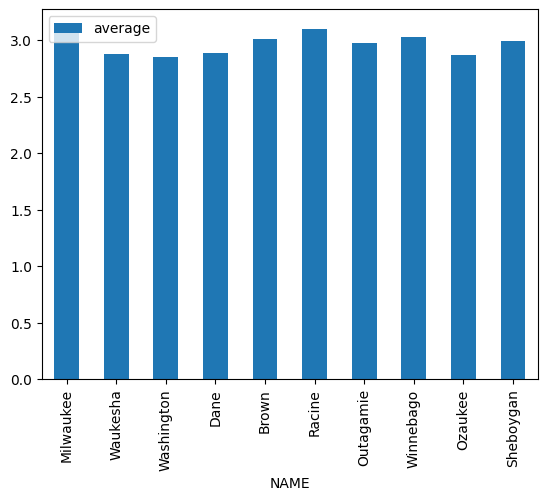

In [20]:
pandas_df.set_index("NAME").plot.bar(y="average")

In [21]:
#q8
df = spark.sql("""
    SELECT county_code, MEAN(interest_rate)
    FROM loans
    GROUP BY county_code
""").explain()
df = spark.sql("""
    SELECT lei, MEAN(interest_rate)
    FROM loans
    GROUP BY lei
""").explain()
# Network I/O is required when data grouped by a specific key is not located in the same partition.
# For the first query to group by county_code, there is not shuffle, such as Exchange operation,
# but there is a shuffle for the second query to group by lei. Therefore, when group by lei,
# it needs to perform a shuffle to redistribute the data for same patition by new key required network I/O.

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[county_code#1000], functions=[mean(cast(interest_rate#1019 as double))])
   +- HashAggregate(keys=[county_code#1000], functions=[partial_mean(cast(interest_rate#1019 as double))])
      +- FileScan parquet spark_catalog.default.loans[county_code#1000,interest_rate#1019] Batched: true, Bucketed: true, DataFilters: [], Format: Parquet, Location: InMemoryFileIndex(1 paths)[hdfs://nn:9000/user/hive/warehouse/loans], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<county_code:string,interest_rate:string>, SelectedBucketsCount: 8 out of 8


== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[lei#997], functions=[mean(cast(interest_rate#1019 as double))])
   +- Exchange hashpartitioning(lei#997, 200), ENSURE_REQUIREMENTS, [plan_id=1096]
      +- HashAggregate(keys=[lei#997], functions=[partial_mean(cast(interest_rate#1019 as double))])
         +- FileScan parquet spark_catalo

In [22]:
df = spark.sql("""
    SELECT * from loans
    LIMIT 3
""").toPandas()
df

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2021,549300FQ2SN6TRRGB032,99999,WI,55055,55055100602,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3351,2.98,69600,112,1201,1689,38
1,2021,254900HA4DQWAE0W3342,31540,WI,55025,55025012700,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,...,NaN,NaN,NaN,4053,3.38,99000,109,1346,1638,27
2,2021,549300FQ2SN6TRRGB032,99999,WI,55113,55113100500,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,3378,3.46,69600,107,1475,4331,34


In [23]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, expr

In [24]:
df = spark.sql("""
    SELECT loan_amount, income, interest_rate, id as approval from loans 
    INNER JOIN action_taken ON loans.action_taken = action_taken.id
""")
df = df.withColumn("income", col("income").cast("double"))
df = df.withColumn("approval", col("approval").cast("double"))
df = df.withColumn("interest_rate", col("interest_rate").cast("double"))
df = df.withColumn("income", expr("IFNULL(income, 0.0)"))
df = df.withColumn("interest_rate", expr("IFNULL(interest_rate, 0.0)"))
df = df.withColumn("approval", expr("CASE WHEN approval != 1 THEN 0.0 ELSE approval END"))
df.show()

+-----------+------+-------------+--------+
|loan_amount|income|interest_rate|approval|
+-----------+------+-------------+--------+
|   255000.0| 210.0|          0.0|     1.0|
|   435000.0|   0.0|        3.125|     0.0|
|   435000.0| 190.0|          0.0|     1.0|
|   165000.0|   0.0|         3.25|     0.0|
|   205000.0|   0.0|          0.0|     1.0|
|   305000.0|   0.0|          3.5|     0.0|
|   195000.0|  43.0|         2.75|     1.0|
|   185000.0|   0.0|          3.5|     0.0|
|   265000.0|  93.0|         2.75|     1.0|
|   185000.0|   0.0|         3.25|     0.0|
|   475000.0|   0.0|        1.999|     1.0|
|   235000.0|   0.0|         3.25|     0.0|
|   425000.0|   0.0|          2.0|     1.0|
|   235000.0|   0.0|         3.25|     0.0|
|   185000.0|   0.0|         2.25|     1.0|
|   385000.0|   0.0|          3.0|     0.0|
|   365000.0| 321.0|        2.625|     1.0|
|   155000.0|   0.0|          2.5|     0.0|
|   245000.0|   0.0|         3.75|     1.0|
|   315000.0|   0.0|          3.

In [25]:
# deterministic split
train, test = df.randomSplit([0.8, 0.2], seed=41) 

In [26]:
#q9
train.rdd.filter(lambda x :x.approval == 1).count()

242868

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier

In [28]:
va = VectorAssembler(inputCols=["loan_amount","income","interest_rate"], outputCol="features")
dt = DecisionTreeClassifier(labelCol="approval", featuresCol="features", maxDepth=5)
va.transform(train).show()

+-----------+------+-------------+--------+----------------+
|loan_amount|income|interest_rate|approval|        features|
+-----------+------+-------------+--------+----------------+
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|          0.0|     0.0|[5000.0,0.0,0.0]|
|     5000.0|   0.0|    

In [29]:
model = dt.fit(va.transform(train))

In [30]:
from pyspark.ml.pipeline import Pipeline, PipelineModel

In [31]:
pipe = Pipeline(stages=[va, dt])

In [32]:
model = pipe.fit(train)
type(pipe), type(model)

(pyspark.ml.pipeline.Pipeline, pyspark.ml.pipeline.PipelineModel)

In [33]:
model.write().overwrite().save("hdfs://nn:9000/model")

In [34]:
model = PipelineModel.load("hdfs://nn:9000/model")

In [35]:
#q10
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="approval", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(model.transform(test))
accuracy


0.8930753904206413